# averaging videos


## load one video

In [1]:
! mkdir -p cache
cache = 'cache'
fname = 'sea-iceland-ocean-water-sky-33194.mp4'
vname = f'{cache}/{fname}'


In [2]:
!brew install yt-dlp

zsh:1: command not found: brew


In [3]:
import os
if not os.path.isfile(vname):
    ! yt-dlp https://pixabay.com/videos/sea-iceland-ocean-water-sky-33194/ --output {vname}

## read video

In [4]:
# !python3.11 -m pip install --upgrade pip av imageio matplotlib

https://pytorch.org/vision/stable/io.html

In [5]:
# !python3.11 -m pip install --upgrade pip torchvision torch tarfile

In [6]:
# from torchvision.io import read_video
# images = read_video(f'{cache}/{fname}')

https://imageio.readthedocs.io/en/stable/examples.html#read-or-iterate-frames-in-a-video

In [7]:
import imageio.v3 as iio

# read a single frame
frame = iio.imread(
    vname,
    index=42,
    plugin="pyav",
)
frame.shape


No accelerated colorspace conversion found from yuv420p to rgb24.


(1080, 1920, 3)

In [8]:
# iterate over large videos
for frame in iio.imiter(vname, plugin="pyav"):
    break

print(frame.shape, frame.dtype)


No accelerated colorspace conversion found from yuv420p to rgb24.


(1080, 1920, 3) uint8


In [9]:
# bulk read all frames
# Warning: large videos will consume a lot of memory (RAM)
frames = iio.imread(vname, plugin="pyav")


No accelerated colorspace conversion found from yuv420p to rgb24.


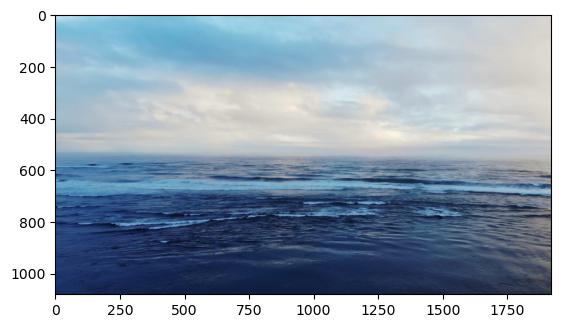

In [10]:
import matplotlib.pyplot as plt
i_image = 42
plt.imshow(frames[i_image, :, :, :])

In [11]:
frames.shape

(956, 1080, 1920, 3)

In [12]:
DS = 2 # spatial downscaling
frames = frames[:, ::DS, ::DS, :]

In [13]:
frames.shape

(956, 540, 960, 3)

## mix time slices from the video

In [14]:
import numpy as np

In [15]:
def full_contrast(image):
    return (image - image.min()) / (image.max() - image.min())
N_T=120


In [16]:
# from tqdm.notebook import trange
from tqdm import trange
def mix(frames, N_average=1000, N_T=N_T):

    N_T_total, N_X, N_Y, three = frames.shape
    frames_mean = np.zeros((N_T, N_X, N_Y, three))
    for i_average in trange(N_average):
        N_T_shift = np.random.randint(N_T_total - N_T)
        frames_mean += frames[N_T_shift:(N_T_shift+N_T), ...]

    return full_contrast(frames_mean)
frames_mean = mix(frames, N_average=200, N_T=120)


100%|██████████| 200/200 [00:55<00:00,  3.58it/s]


In [17]:
iio.immeta(vname, plugin="pyav")

No accelerated colorspace conversion found from yuv420p to rgb24.
 (repeated 955 more times)
/Users/laurentperrinet/opt/anaconda3/envs/stim/lib/python3.10/site-packages/imageio/plugins/pyav.py:699: UserWarning: PyAV 10.0.0 has known issues reading metadata. If you need video metadata consider using v9.2.0 instead.
  warnings.warn(


{'video_format': 'yuv420p',
 'codec': 'h264',
 'long_codec': 'H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10',
 'profile': 'High',
 'duration': 39.87316666666667,
 'fps': 23.976023976023978,
 'major_brand': 'mp42',
 'minor_version': '0',
 'compatible_brands': 'mp42mp41isomavc1',
 'creation_time': '2020-03-06T20:27:40.000000Z',
 'language': 'und',
 'handler_name': 'L-SMASH Video Handler',
 'vendor_id': '[0][0][0][0]',
 'encoder': 'AVC Coding'}

In [18]:
fps = np.ceil(iio.immeta(vname, plugin="pyav")["fps"])
out_vname = f'{cache}/out_{fname}'

with iio.imopen(out_vname, "w", plugin="pyav") as out_file:
    out_file.init_video_stream("h264", fps=fps)
    for i_frame in range(N_T):
        out_file.write_frame((frames_mean[i_frame, ...]*255).astype(np.uint8))